# Случайный лес

Ключевым недостатком деревьев решений является их "склонность" к переобучению, а также тот факт, что даже при небольшом изменении обучающей выборки дерево может значительно измениться. Однако объединение деревьев в _ансамбли_ или _композиции_ на практике дает очень хорошие результаты. Ансамбли - это методы, сочетающие в себе несколько алгоритмов машинного обучения для повышения качества работы модели.

В случае задачи регрессии при использовании композиции $a(x)$ из $N$ _базовых алгоритмов_ $b_{n}(x)$ ответом будет считаться среднее значение ответа каждого алгоритма

$$a(x) = \frac{1}{N}\sum_{n=1}^{N}b_{n}(x),$$

в задачах классификации, соответственно, знак полученного усредненного ответа или (что аналогично) класс определяется путем _голосования_: объект относится к классу, за который "проголосовало" наибольшее число базовых алгоритмов.

Случайный лес формируют из деревьев решения.

"Случайными" леса называны из-за того, что в процесс построения деревьев, из которых они состоят, внесен элемент случайности для обеспечения уникальности каждого из деревьев. Случайность заключается в обучении базовых алгоритмов на разных подвыборках обучающей выборки.

Один из способов построения случайных подвыборок - _бутстрап (bootstrap)_. Этот метод заключается в получении из выборки длины $l$ нескольких разных выборок той же длины $l$ за счёт копирования элементов. Для получения бутстрап-выборки из исходной выборки $l$ раз выбирается случайный элемент, причем каждый раз новый элемент выбирается из всей выборки. Таким образом, в полученной в конечном итоге бутстрап-выборке некоторые элементы исходной выборки будут встречаться несколько раз, а некоторые (примерно 37% выборки) будут вовсе отсутствовать, и при повторении $N$ раз мы получим $N$ разных выборок длиной $l$.

Например, если у нас есть исходная выборка вида [a, b, c, d, e], возможными бутстрап-выборками могут быть [a, b, a, c, b] или [b, e, e, d, b] и т.д.

При построении случайного леса вначале создаётсяя набор бутстрап-выборок под каждое будущее дерево в "лесу". Для уменьшения корреляции базовых алгоритмов случайным делается и процесс построения каждого дерева: если в стандартном методе построения деревьев мы в каждом узле выбираем $j$-й признак и порог $t$, с которым сравнивается его значение, и потом эти значения оптимизируются с помощью функции ошибки, то в методе случайного леса в каждой вершине $j$-й признак выбирается не из всего пространства признаков, а из его случайного подмножества размера $m$, __которое каждый раз выбирается заново__ (в этом отличие от метода случайных подпространств, где подпространство выбирается единожды и используется для построения всего дерева).

В задачах классификации рекомендуется брать $m = \sqrt{d}$, где $d$ - общее число признаков, и строить дерево до тех пор, пока в каждом листе не останется по одному объекту, а в задаче регрессии принимать $m = d/3$ и строить дерево, пока в листьях не останется по пять объектов.

Далее построенные деревья объединяются в композицию, и при предсказаниях с его помощью используется усредненный ответ на каждом дереве.

In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

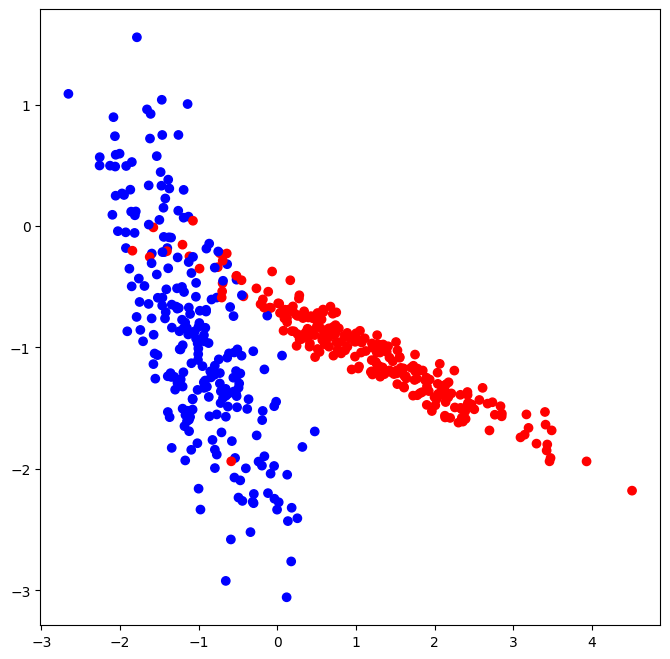

In [ ]:
# сгенерируем данные, представляющие собой 500 объектов с 2-мя признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=23)

# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors);

In [ ]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]  # Количество объектов в исходной выборке
    bootstrap = []             # Список для хранения бутстрап-выборок

    for i in range(N):  # Создаем N бутстрап-выборок
        # Создаем пустые массивы для новой выборки
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)

        # Заполняем новую выборку
        for j in range(n_samples):
            # Ключевой момент: выбираем случайный индекс С ВОЗВРАЩЕНИЕМ
            idx = random.randint(0, n_samples - 1)

            # Копируем объект с выбранным индексом
            b_data[j] = data[idx]      # Признаки
            b_labels[j] = labels[idx]  # Метка класса

        bootstrap.append((b_data, b_labels))

    return bootstrap

In [ ]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]

    len_subsample = int(np.sqrt(len_sample))
    subsample = []

    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())

    return subsample

In [ ]:
# Реализуем класс узла

class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# И класс терминального узла (листа)

class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # В листе возвращаем класс с наибольшим количеством объектов
        classes, counts = np.unique(self.labels, return_counts=True)
        prediction = classes[np.argmax(counts)]
        return prediction

In [ ]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity


In [ ]:
# Расчет качества
def quality(left_labels, right_labels, current_gini):
    # доля выбранного подмножества
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


In [ ]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels


In [ ]:
# Нахождение наилучшего разбиения


def find_best_split(data, labels, feature_indexes):
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    # выбираем случайное подмножество признаков
    if feature_indexes is not None:
        features = feature_indexes
    else:
        features = range(n_features)

    for index in features:
        # будем проверять только уникальные значения признака
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_labels) < min_leaf or len(false_labels) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [ ]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):
    n_features = data.shape[1]

    # Для первого разбиения выбираем случайное подмножество признаков
    m = int(np.sqrt(n_features))
    feature_indexes = random.sample(range(n_features), m)

    quality, t, index = find_best_split(data, labels, feature_indexes)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


In [ ]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)

    # строим лес
    for b_data, b_labels in bootstrap:
        tree = build_tree(b_data, b_labels)
        forest.append(tree)

    return forest


In [ ]:
# Функция классификации отдельного объекта

def classify_object(obj, node):
    if isinstance(node, Leaf):
        return node.prediction

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)


In [ ]:
# функция формирования предсказания по выборке на одном дереве
def predict(data, tree):
    classes = []

    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)

    return classes

In [ ]:
# предсказание голосованием деревьев

def tree_vote(forest, data):
    # предсказания каждого дерева
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

    # транспонируем матрицу предсказаний
    predictions = np.array(predictions).T

    # для каждого объекта выбираем класс с наибольшим количеством голосов
    voted_predictions = []
    for obj_predictions in predictions:
        classes, counts = np.unique(obj_predictions, return_counts=True)
        voted_predictions.append(classes[np.argmax(counts)])

    return voted_predictions

In [ ]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [ ]:
  # Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
      if actual[i] == predicted[i]:
        correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:
for n_trees in [1, 10, 50, 100]:
    my_forest = random_forest(train_data, train_labels, n_trees)

    # Получим ответы для обучающей выборки
    train_answers = tree_vote(my_forest, train_data)

    # И получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest, test_data)

    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 47.143
Точность случайного леса из 1 деревьев на тестовой выборке: 58.667
Точность случайного леса из 10 деревьев на обучающей выборке: 47.143
Точность случайного леса из 10 деревьев на тестовой выборке: 58.667
Точность случайного леса из 50 деревьев на обучающей выборке: 47.143
Точность случайного леса из 50 деревьев на тестовой выборке: 58.667
Точность случайного леса из 100 деревьев на обучающей выборке: 47.143
Точность случайного леса из 100 деревьев на тестовой выборке: 58.667


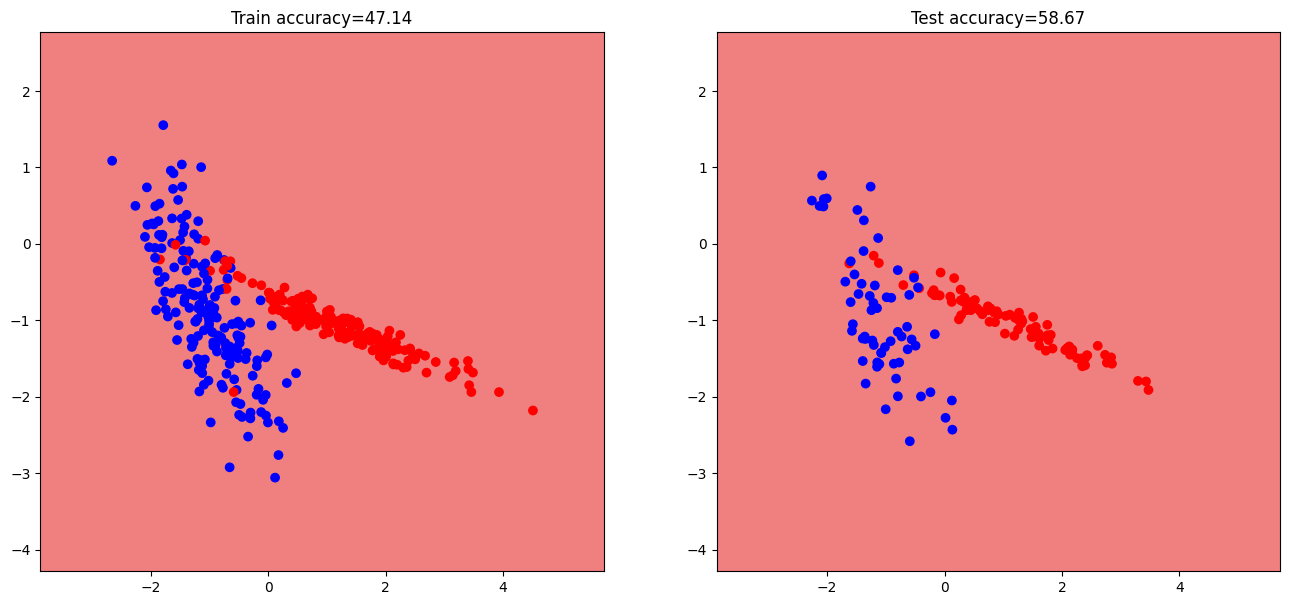

In [ ]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

# Создаем лес из 10 деревьев для визуализации
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)
train_answers_10 = tree_vote(my_forest_10, train_data)
test_answers_10 = tree_vote(my_forest_10, test_data)
train_accuracy_10 = accuracy_metric(train_labels, train_answers_10)
test_accuracy_10 = accuracy_metric(test_labels, test_answers_10)

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_10:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_10:.2f}')
plt.show()


In [ ]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_3, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 47.143
Точность случайного леса из 3 деревьев на тестовой выборке: 58.667


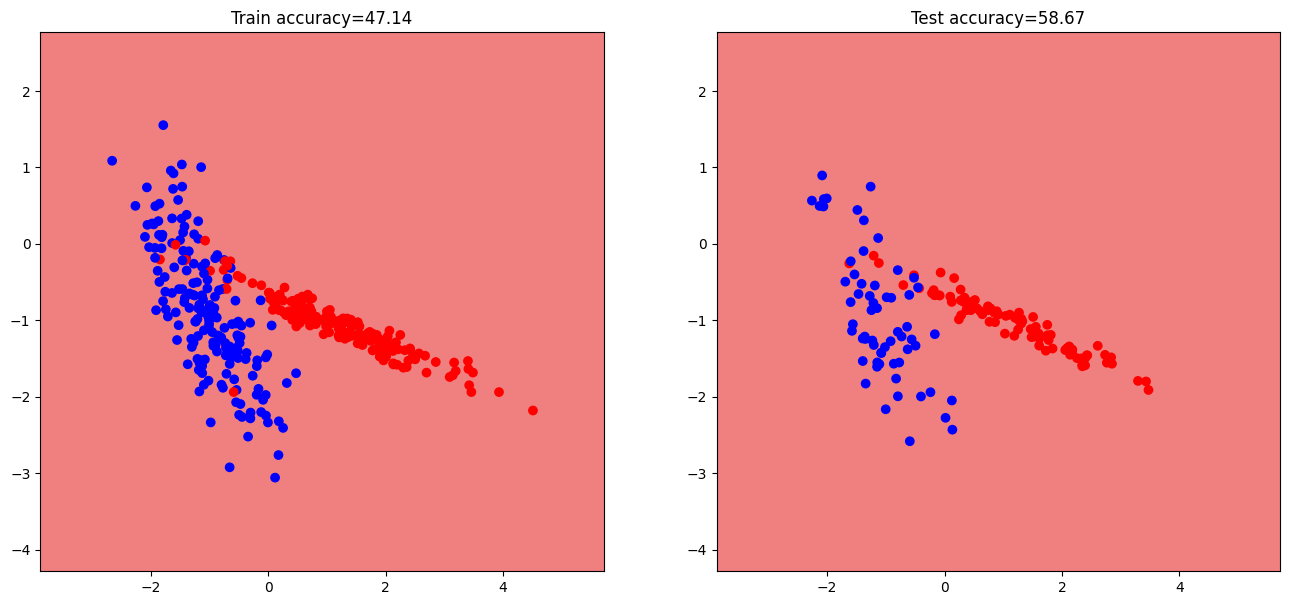

In [ ]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()


In [ ]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_10, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 47.143
Точность случайного леса из 10 деревьев на тестовой выборке: 58.667


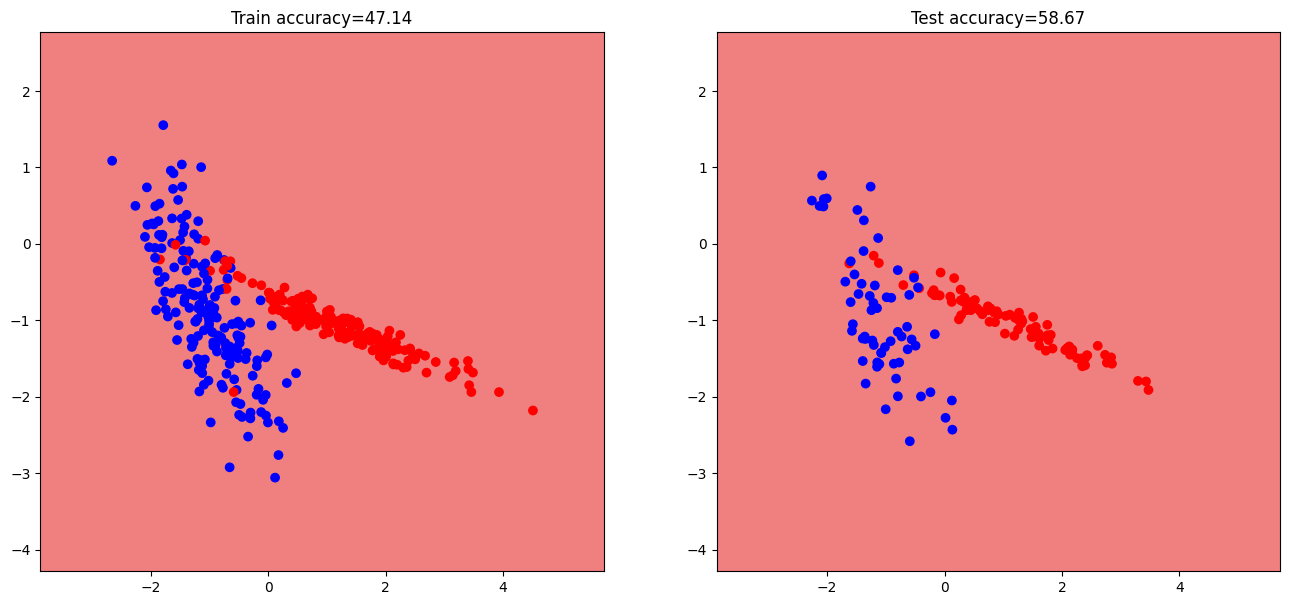

In [ ]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()


In [ ]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_50, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 47.143
Точность случайного леса из 50 деревьев на тестовой выборке: 58.667


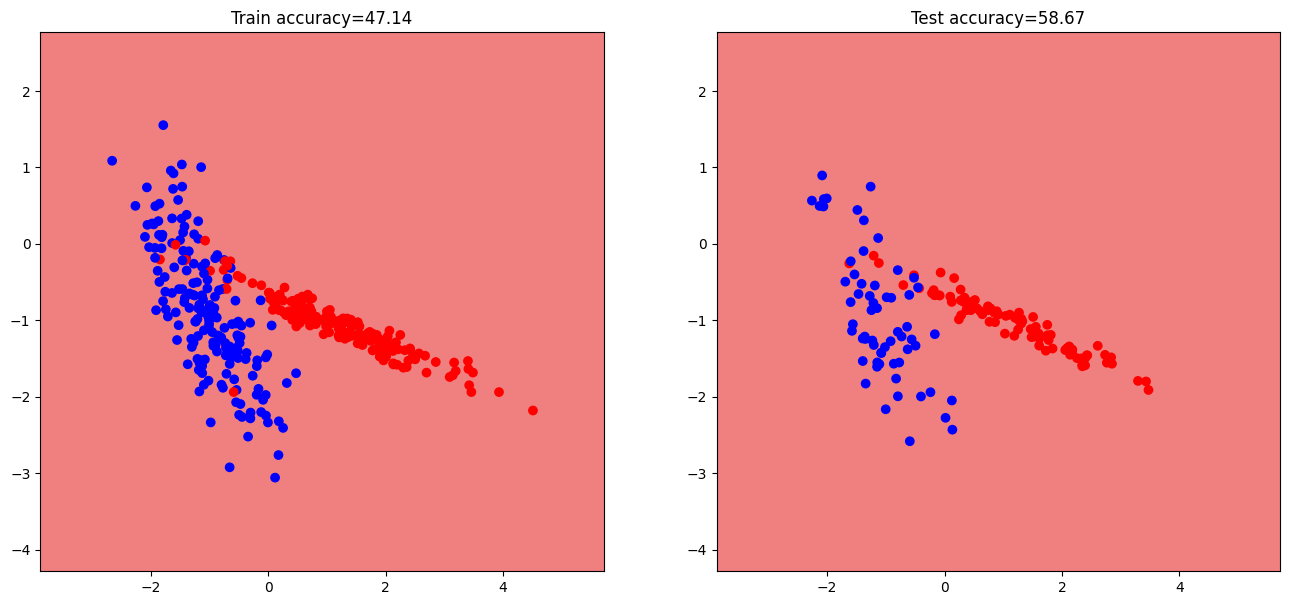

In [ ]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()